# Libraries uploading

In [34]:
#basic operations
from typing import Union, Tuple, Optional

#math core
import numpy as np
from numpy.random import RandomState

import scipy
from scipy import signal
from scipy.optimize import minimize
from scipy.signal import butter, tukey, filtfilt

#visualization core
import matplotlib.pyplot as plt

# Defining functions

In [35]:
class Operator:
    """
    A class containing static methods to generate convolution operators for various purposes.
    """
    @staticmethod
    def _convolve_operator(kernel: Union[list, np.ndarray], nt: int, offset: Optional[int] = None) -> np.ndarray:
        """
        Computes the discrete linear convolution operator for two one-dimensional sequences.

        Args:
            kernel (list or np.ndarray): First input array.
            nt (int): Length of the output array after convolution.
            offset (int, optional): Offset (default is half the length of `kernel`).

        Returns:
            np.ndarray: Convolution operator (nt, nt).

        Example:
            >>> kernel = [1, 2, 3]
            >>> nt = 5
            >>> result = convolve_operator(kernel, nt)
            >>> print(result)
            [[2. 3. 0. 0. 0.]
             [1. 2. 3. 0. 0.]
             [0. 1. 2. 3. 0.]
             [0. 0. 1. 2. 3.]
             [0. 0. 0. 1. 2.]]
        """
        try:
            # Calculate the offset if not provided
            offset = len(kernel) // 2 if offset is None else offset

            # Construct the first column and first row for Toeplitz matrix
            first_col, first_row = np.r_[kernel, np.zeros(nt + offset)], np.r_[kernel[0], np.zeros(nt - 1)]

            # Create the Toeplitz matrix and extract the relevant part
            operator = scipy.linalg.toeplitz(first_col, first_row)[offset: offset + nt]

            return operator
        except Exception as e:
            print(f"Error in _convolve_operator: {e}")
            return np.array([])

    @classmethod
    def first_derivative(cls, nt: int, mode: str = "forward") -> np.ndarray:
        """
        Generates a first-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: First-order derivative convolution operator (nt, nt).
            
        Example:
            >>> nt = 4
            >>> result = first_derivative(nt)
            >>> print(result)
            [[-1.  1.  0.  0.]
             [ 0. -1.  1.  0.]
             [ 0.  0. -1.  1.]
             [ 0.  0.  0. -1.]]
        
        """
        
        try:
            if mode == "forward":
                operator = cls._convolve_operator([-1, 1], nt, offset=1)
                operator[-1, :] = 0
            elif mode == "centered":
                operator = cls._convolve_operator([1, 0,-1], nt)
            return operator
        except Exception as e:
            print(f"Error in first_derivative: {e}")
            return np.array([])

    @classmethod
    def second_derivative(cls, nt: int) -> np.ndarray:
        """
        Generates a second-order derivative convolution operator.

        Args:
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Second-order derivative convolution operator (nt, nt).
        """
        try:
            operator = cls._convolve_operator([-1, 2, -1], nt, offset=2)
            operator[-2:, :] = 0
            return operator
        except Exception as e:
            print(f"Error in second_derivative: {e}")
            return np.array([])

    @classmethod
    def wavelet_operator(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Generates a convolution operator using the provided wavelet.

        Args:
            wavelet (list or np.ndarray): Wavelet array.
            nt (int): Length of the output array after convolution.

        Returns:
            np.ndarray: Convolution operator using the provided wavelet (nt, nt).
        """
        try:
            operator = cls._convolve_operator(wavelet, nt)
            return operator
        except Exception as e:
            print(f"Error in wavelet_operator: {e}")
            return np.array([])

    @classmethod
    def acoustic(cls, wavelet: Union[list, np.ndarray], nt: int) -> np.ndarray:
        """
        Computes the acoustic operator (W*D, according to the convolutional model of seismic trace) 
        for a given wavelet and length of the output array.

        Args:
            wavelet (list or np.ndarray): One-dimensional array representing the wavelet.
            nt (int): Length of the output array.

        Returns:
            np.ndarray: Acoustic operator (nt, nt).

        Example:
            >>> wavelet = [1, -1, 2]
            >>> nt = 4
            >>> result = acoustic_operator(wavelet, nt)
            >>> print(result)
            [[-1.  2. -1.  0.]
             [ 2. -3.  2. -1.]
             [ 0.  2. -3.  2.]
             [ 0.  0.  2. -3.]]
        """
        try:
            return cls.wavelet_operator(wavelet, nt) @ cls.first_derivative(nt)
        except Exception as e:
            print(f"Error in acoustic: {e}")
            return np.array([])
    

    @classmethod
    def akirichards(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def fatti(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def ps(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def zoeppritz(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def tikhonov(cls, input_data) -> np.ndarray:
        pass
    
    @classmethod
    def avo(cls, input_data) -> np.ndarray:
        pass


In [36]:
def mse(L: Union[list, np.ndarray], L0: Union[list, np.ndarray], T: Union[list, np.ndarray],
        acoustic_operator: Union[list, np.ndarray], derivative_operator: Union[list, np.ndarray],
        alpha: Union[float, int]) -> float:
    """
    Computes the Mean Squared Error (MSE) between modeled seismic trace and real trace.

    Args:
        L (list or np.ndarray): Low-frequency model to change.
        L0 (list or np.ndarray): Low-frequency model.
        T (list or np.ndarray): Real seismic trace to compare.
        acoustic_operator (list or np.ndarray): Acoustic operator matrix.
        alpha (float or int): Regularization parameter.

    Returns:
        float: Mean Squared Error.

    Example:
        >>> L = [1, 2, 3]
        >>> L0 = [0, 0, 0]
        >>> T = [1, 2, 3]
        >>> acoustic_operator = [[-1, 1, 0], [1, -1, 2], [0, 1, -1]]
        >>> alpha = 0.1
        >>> result = mse(L, L0, T, acoustic_operator, alpha)
        >>> print(result)
        5.374165738677394
    """
    L, L0, T, acoustic_operator = np.array(L), np.array(L0), np.array(T), np.array(acoustic_operator)
    # Compute the main term of the MSE
    main_term = np.mean(np.sqrt((np.dot(acoustic_operator, L) - T) ** 2))
    
    # Compute the regularization term of the MSE
    regularization_term = alpha*np.mean(np.sqrt((derivative_operator@(L - L0)) ** 2))
    
    # Return the sum of main and regularization terms
    return main_term + regularization_term

def butter_lowpass_filter(data, cutoff, fs, order):
    """
    Lowpass filter
    fs - sample rate (шаг дискретизации), Hz
    cutoff - desired cutoff frequency of the filter (желаемая частота среза фильтра), Hz
    order - sin wave can be approx represented as quadratic
    """
    normal_cutoff = 2*cutoff / fs
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Data modelling

C:\Users\Владислав\AppData\Local\Temp\ipykernel_2248\1275002066.py:9: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = signal.ricker(points, a)


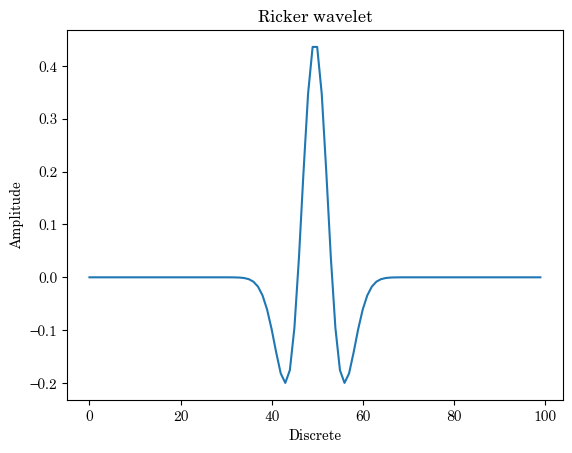

In [37]:
# Define parameters
points = 100  # Number of points in the wavelet
dt = 0.002  # Time step
bfreq = 1. / dt  # Base frequency calculated based on the time step
mean_freq = 30  # Mean frequency of the Ricker wavelet
a = bfreq / (np.sqrt(2.0) * np.pi * mean_freq)  # Parameter used in the Ricker wavelet formula

# Generate Ricker wavelet using scipy's signal.ricker
wavelet = signal.ricker(points, a)

plt.plot(wavelet)
plt.title("Ricker wavelet")
plt.xlabel("Discrete")
plt.ylabel("Amplitude")
plt.show()

In [38]:
rs = RandomState(42)

nt = 500 #the length of traces

impedance = np.zeros(nt)

thickness = 80
global_variations_amplitude = 700
local_variations_amplitude = 350
trend_slope = 4
trend_intercept = 5000

low_frequency_trend = trend_slope*np.arange(nt) + trend_intercept

for i in range(thickness, nt):
    if not i%thickness:
        impedance[i-thickness: i] = rs.randint(-global_variations_amplitude, global_variations_amplitude) 
        
impedance += rs.normal(loc = 0.00, scale = local_variations_amplitude, size = (nt))
impedance += low_frequency_trend
 
impedance_smoothed = scipy.ndimage.gaussian_filter(impedance, 2)
low_frequency_model = butter_lowpass_filter(impedance, cutoff = 8, fs = nt, order = 2)

In [39]:
seismic_trace = Operator.acoustic(wavelet, nt)@np.log(impedance_smoothed)
# seismic_trace *= signal.tukey(nt, 0.1)

power = np.abs(np.fft.rfft(seismic_trace)) 
frequency = np.fft.rfftfreq(len(seismic_trace), 0.002) 

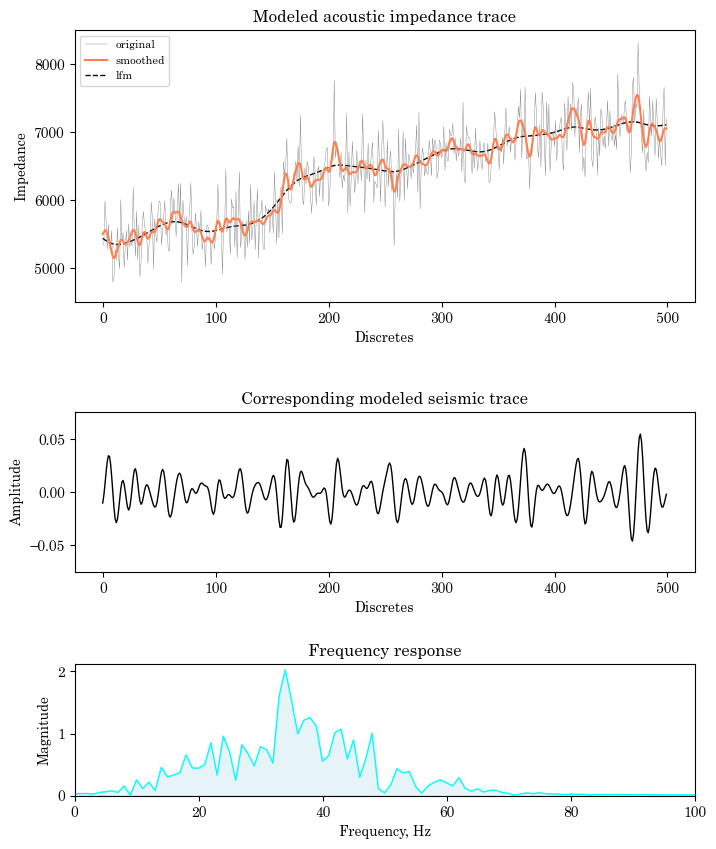

In [40]:
plt.rcParams["font.family"] = "century"

plt.figure(figsize = (8, 12))

plt.subplot(3, 1, 1)
plt.plot(impedance, "grey", lw = 0.3, label = "original")
plt.plot(impedance_smoothed, c = "coral", lw = 1.5, zorder = 2, label = "smoothed")
plt.plot(low_frequency_model, c = "black", ls = "--", lw = 1, zorder = 1, label = "lfm")
plt.ylim([4500, 8500])
plt.yticks(np.arange(5e3, 8.1e3, 1e3))
plt.title("Modeled acoustic impedance trace")
plt.ylabel("Impedance")
plt.xlabel("Discretes")
plt.legend(fontsize = 8)

plt.subplot(5, 1, 3)
plt.plot(seismic_trace, c = "black", lw = 1)
plt.ylim([-0.075, 0.075])
# plt.yticks(np.arange(4e3, 8.1e3, 1e3))
plt.title("Corresponding modeled seismic trace")
plt.ylabel("Amplitude")
plt.xlabel("Discretes")

plt.subplot(6, 1, 5)
plt.title("Frequency response")
plt.plot(frequency, np.abs(power), c = "aqua", lw = 1)
plt.xlim([0, 100])
plt.ylim([0, None])
plt.xlabel("Frequency, Hz")
plt.ylabel("Magnitude")
plt.fill_between(frequency, np.abs(power),
                color='lightblue', alpha=0.3)

plt.show()

# Inversion procedure

In [41]:
result = np.exp(minimize(mse,
                  x0 = np.log(low_frequency_model),
                  args = (np.log(low_frequency_model), 
                          seismic_trace, 
                          Operator.acoustic(wavelet, nt), 
                          Operator.first_derivative(nt, mode = "centered"),
                          1e-3),
                  method = 'L-BFGS-B',options={'disp': True}, 
                  tol = 1e-15).x)

In [42]:
import scipy.sparse.linalg 

In [43]:
res_lsqr = np.exp(scipy.sparse.linalg.gcrotmk(Operator.acoustic(wavelet, nt), 
                       seismic_trace, 
                       x0 = np.log(low_frequency_model)
                       )[0])

C:\Users\Владислав\AppData\Local\Temp\ipykernel_2248\1459708215.py:1: DeprecationWarning: 'scipy.sparse.linalg.gcrotmk' called without specifying `atol`. This behavior is deprecated and will result in an error in SciPy v1.14.0. To preserve current behaviour, set `atol=rtol`, or, to adopt the future default, set `atol=0.0`.
  res_lsqr = np.exp(scipy.sparse.linalg.gcrotmk(Operator.acoustic(wavelet, nt),


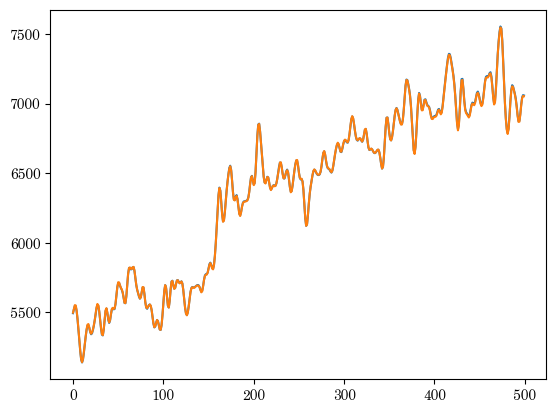

In [44]:
plt.plot(res_lsqr)
plt.plot(impedance_smoothed)

In [45]:
correlation_coefficient = np.corrcoef(result, impedance_smoothed)[0, 1]

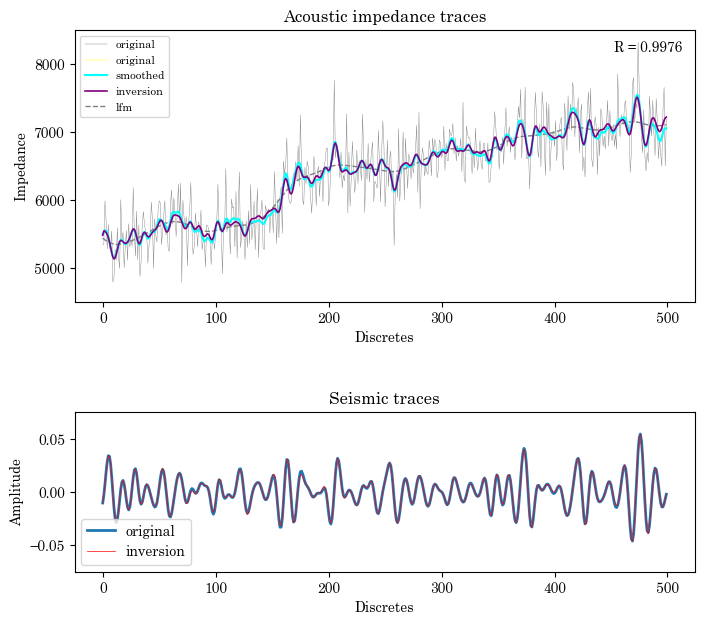

In [46]:
plt.rcParams["font.family"] = "century"

plt.figure(figsize = (8, 12))

plt.subplot(3, 1, 1)
plt.plot(impedance, "grey", lw = 0.3, label = "original")
plt.plot(res_lsqr, "yellow", lw = 0.3, label = "original")
plt.plot(impedance_smoothed, c = "aqua", lw = 1.5, zorder = 2, label = "smoothed")
plt.plot(result, c = "purple", lw = 1.2, zorder = 2, label = "inversion")
plt.plot(low_frequency_model, c = "gray", ls = "--", lw = 1, zorder = 1, label = "lfm")
plt.ylim([4500, 8500])
plt.yticks(np.arange(5e3, 8.1e3, 1e3))
plt.text(0.98, 0.96, 'R = {:.4f}'.format(correlation_coefficient),
         horizontalalignment='right',
         verticalalignment='top',
         transform=plt.gca().transAxes)
plt.title("Acoustic impedance traces")
plt.ylabel("Impedance")
plt.xlabel("Discretes")
plt.legend(fontsize = 8)


plt.subplot(5, 1, 3)
plt.plot(seismic_trace, c = "C0", lw = 2, label = "original")
plt.plot(Operator.acoustic(wavelet, nt)@np.log(result), c = "red", lw = 0.5, label = "inversion")
plt.ylim([-0.075, 0.075])
plt.title("Seismic traces")
plt.ylabel("Amplitude")
plt.xlabel("Discretes")
plt.legend()